In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull
from yellowbrick.cluster.elbow import kelbow_visualizer

# Теорія

## Означення

Кластерний аналіз (англ. Data clustering) — задача розбиття заданої вибірки об'єктів (ситуацій) на підмножини, які називаються кластерами, так, щоб кожен кластер складався зі схожих об'єктів, а об'єкти різних кластерів істотно відрізнялися. Задача кластеризації належить до статистичної обробки, а також до широкого класу завдань некерованого навчання.

Кластериза́ція ме́тодом k-сере́дніх (англ. k-means clustering) - впорядкування множини об'єктів у порівняно однорідні групи.

Мета методу - розділити $n$ спостережень на $k$ кластерів, так щоб кожне спостереження належало до кластера з найближчим до нього середнім значенням. Метод базується на мінімізації суми квадратів відстаней між кожним спостереженням та центром його кластера, тобто функції:

\begin{equation*}
    J = \sum_{i=1}^{n} \sum_{j=1}^{k} (x_i - с_j)^2
\end{equation*}

де $k$ — число кластерів, $n$ — число спостережень, $x_i$ - $i$-те спостереження, $c_j$ - центри мас $j$-го кластера.

Фунцкція $J$ - це функція втрат, котру для кластеризації ще називають `distortion`.

## Алгоритм методу «Кластеризація за схемою k-середніх»:

Маємо масив спостережень (об'єктів), кожен з яких має певні значення за рядом ознак. Відповідно до цих значень об'єкт розташовується у багатовимірному просторі.

1. Дослідник визначає кількість кластерів, що необхідно утворити.
2. Випадковим чином обирається $n$ спостережень, які на цьому кроці вважаються центрами кластерів.
3. Кожне спостереження «приписується» до одного з $k$ кластерів — того, відстань до якого найкоротша.
4. Розраховується новий центр кожного кластера як елемент, ознаки якого розраховуються як середнє арифметичне ознак об'єктів, що входять у цей кластер.
5. Відбувається така кількість ітерацій (повторюються кроки 3-4), поки кластерні центри стануть стійкими (тобто при кожній ітерації в кожен кластер потрапляють одні й ті самі об'єкти), дисперсія всередині кластера буде мінімізована, а між кластерами — максимізована.

Вибір кількості кластерів робиться на основі дослідницької гіпотези. Якщо її немає, то рекомендують спочатку створити 2 кластери, далі 3, 4, 5, порівнюючи отримані результати.

## Метод "ліктя"

Метод ліктя передбачає багаторазове циклічне виконання алгоритму зі збільшенням кількості кластерів, а також подальшим відкладанням на графіку функції втрат (`distortion`).

Характерный график выглядит так:

![Alt text](image/kmean.png)

Графік "ліктя" показує залежність функції втрат $J$ від кількості кластерів $k$. Якщо на графіку можна виокремити точку згину (так званий "лікоть"), то це може свідчити про те, що відповідна кількість кластерів є оптимальною.

## Посилання

1. [Документация skikit-learn. 2.3. Кластеризация](https://scikit-learn.ru/clustering/#)
2. [sklearn.cluster.KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
3. [Алгоритм кластеризации Ллойда (K-средних, K-means)](https://www.youtube.com/watch?v=8vCuR1AndH0)
4. [Модель кластеризации KMeans](https://www.youtube.com/watch?v=EHZJMz6zyFE&ab_channel=machinelearrrning)
5. [Метод локтя для модели KMeans с нуля](https://youtu.be/BEhLlqkL-f4)
6. [Кластеризуем лучше, чем «метод локтя»](https://habr.com/ru/companies/jetinfosystems/articles/467745/)
7. [Кластерный анализ](https://www.dmitrymakarov.ru/intro/clustering-16/)

# Функції

## Функція для пошуку кластерів

In [2]:
def find_optimal_clusters(features, max_clusters, random_state=0) -> list:
    """
    Find the optimal number of clusters using the 'Elbow Method' for K-Means clustering.

    Parameters:
        data (array-like): The input data for clustering.
        max_clusters (int): The maximum number of clusters to consider.

    Returns:
        distortions: list of distorsions

    This function calculates the distortion (inertia) for different numbers of clusters
    ranging from 1 to max_clusters and plots a 'Elbow Method' graph to help choose the
    optimal number of clusters for K-Means clustering. The point where the distortion
    starts to decrease at a slower rate often indicates the optimal number of clusters.
    """
    
    distortions = []
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(
            n_clusters=i,
            init="k-means++",
            max_iter=100,
            n_init="auto",
            random_state=random_state,
        ).fit(features)
        distortions.append(kmeans.inertia_)
    
    # plotting
    plt.plot(range(1, max_clusters + 1), distortions, marker='D', color='b')
    plt.plot(range(1, max_clusters + 1), distortions, marker='D', color='b')
    plt.xticks(range(1, max_clusters + 1), rotation=45)
    plt.xlabel(r"Number of clusters, $k$")
    plt.ylabel(r"Loss function (distortion)")
    plt.title("Elbow chart")
    plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
    plt.show()

    return distortions

## Функція для виконання алгоритму кластеризації за методом K-Means

In [3]:
def perform_kmeans_clustering(features, n_clusters=8, random_state=0):
    """
    Performs clustering using the K-Means method and returns cluster labels and centroid coordinates.

    Parameters:
    - features: The array of features to cluster.
    - n_clusters: Number of clusters (default is 8).
    - random_state: The seed for generating random numbers (default 0).

    Returns:
    - cluster_labels: An array of cluster labels.
    - centroids: The coordinates of the centroids of the clusters.
    """

    # Create a K-Means object
    kmeans = KMeans(
        n_clusters=n_clusters,
        init="k-means++",
        max_iter=100,
        n_init="auto",
        random_state=0,
    )

    # Clustering
    kmeans.fit(features)

    # Get cluster labels
    cluster_labels = kmeans.labels_

    # Пget the coordinates of centroids
    centroids = kmeans.cluster_centers_

    return cluster_labels, centroids

## Функція для візуалізації кластерів з опуклими оболонками та центроїдами.

In [4]:
def plot_clusters_with_convex_hulls(X, cluster_labels, centroids, k):
    """
    Function to visualize clusters with convex shells and centroids.

    Parameters:
    - X: Data matrix (n_samples, n_features).
    - y: Class Tags.
    - cluster_labels: Array with cluster labels for each point in X.
    - centroids: Matrix with the coordinates of the centroids of the clusters (k, n_features).
    - k: The number of clusters.

    Result:
    - Visualization with clusters, convex hulls and centroids.
    """
    fig, ax = plt.subplots()
    cmap = plt.get_cmap("inferno")

    hull_list = [ConvexHull(X[cluster_labels == i]) for i in range(k)]

    for i, hull in enumerate(hull_list):
        cluster_points = X[cluster_labels == i]
        cluster_color = cmap(i / k)
        plt.scatter(
            cluster_points[:, 0],
            cluster_points[:, 1],
            s=10,
            color=cluster_color,
            label=f"Cluster {i+1}",
        )

        for simplex in hull.simplices:
            plt.plot(
                cluster_points[simplex, 0],
                cluster_points[simplex, 1],
                color=cluster_color,
                linewidth=1,
                linestyle="--",
            )

        ax.fill(
            cluster_points[hull.vertices, 0],
            cluster_points[hull.vertices, 1],
            facecolor=cluster_color,
            alpha=0.2,
        )

    ax.scatter(centroids[:, 0], centroids[:, 1], s=75, marker="x", c="r")
    ax.set_facecolor("#f5f5f5")
    plt.xlabel("component 1")
    plt.ylabel("component 2")
    plt.legend()
    plt.show()

# Двовимірний датасет `data_2d`

In [5]:
data_2d = pd.read_csv("data/data_2d.csv", header=None)
data_2d

,0,1,2
0,0.0,-0.768716,0.460860
1,0.0,2.687848,2.366961
2,0.0,-0.201379,0.470430
3,0.0,0.608496,1.225400
4,0.0,-0.082282,1.137218
...,...,...,...
195,1.0,0.629144,4.378584
196,1.0,-0.723824,5.361801
197,1.0,1.346107,2.333476
198,1.0,3.608219,3.411546




Цей набір даних складається з 200 рядків і 3 стовпців. Перший стовпчик - це клас, який може набувати лише двох значень: $0$ або $1$. Другий стовпець - це перша ознака, яка є дійсним числом. Третій стовпець - це друга ознака, яка також є дійсним числом. 


Побудуємо розподіл даних.

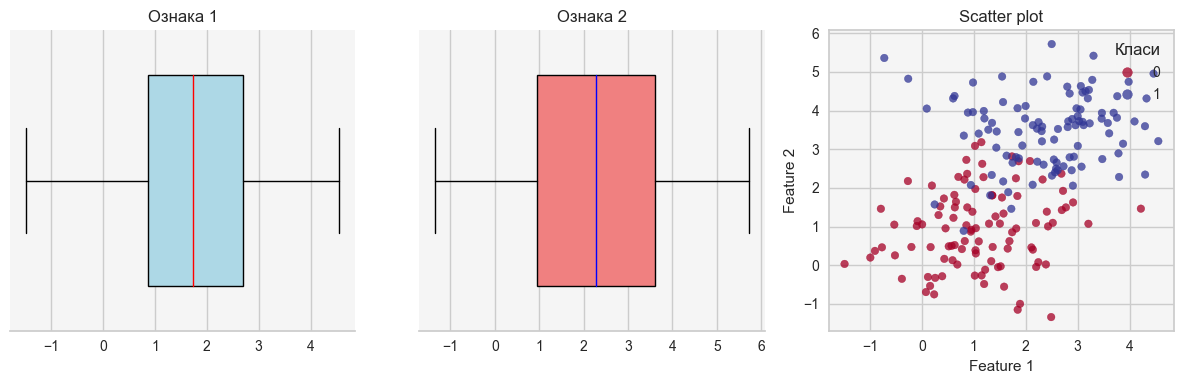

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# Ознака 1 - Графік "ящик із вусами"
ax1.boxplot(
    data_2d[1],
    vert=False,
    widths=0.7,
    patch_artist=True,
    boxprops=dict(facecolor="lightblue"),
    medianprops={"color": "red"},
)
ax1.set_title("Ознака 1")
ax1.set_yticks([])
ax1.spines["left"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)

# Ознака 2 - Графік "ящик із вусами"
ax2.boxplot(
    data_2d[2],
    vert=False,
    widths=0.7,
    patch_artist=True,
    boxprops=dict(facecolor="lightcoral"),
    medianprops={"color": "blue"},
)
ax2.set_title("Ознака 2")
ax2.set_yticks([])
ax2.spines["left"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# Діаграма розсіювання
scatter = ax3.scatter(
    data_2d[1], data_2d[2], c=data_2d[0], s=30, cmap="RdYlBu", alpha=0.75
)
ax3.set_title("Scatter plot")
ax3.set_xlabel("Feature 1")
ax3.set_ylabel("Feature 2")
ax3.legend(*scatter.legend_elements(), title="Класи", loc="upper right")

plt.tight_layout()

# Додамо кольорові фони для кожного графіка
ax1.set_facecolor("#f5f5f5")
ax2.set_facecolor("#f5f5f5")
ax3.set_facecolor("#f5f5f5")

plt.show()

In [7]:
# Розрахунок кореляції
corr = np.corrcoef(data_2d[1], data_2d[2])
print(corr[0, 1].round(2))

0.49


На основі графіків та коефіцієнта кореляції можна зробити висновки про дані:
- Розподіл першої ознаки: нормальний.
- Розподіл другої ознаки: нормальний.
- Кореляція між ознаками: слабка.

## Знаходження оптимальної кількості кластерів

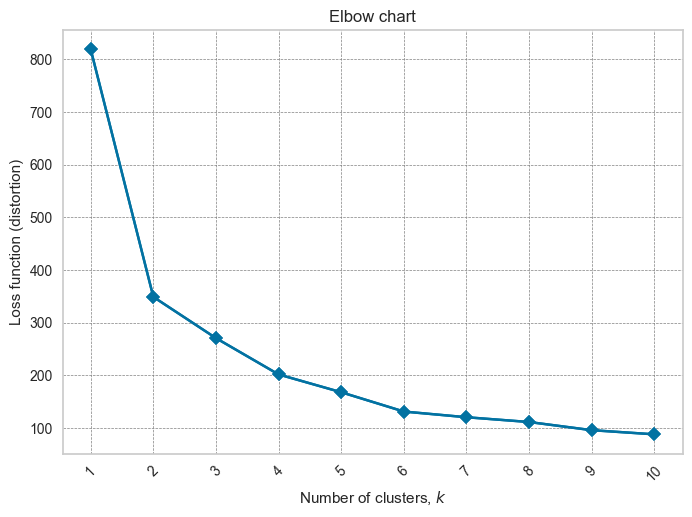

In [8]:
X_data_2d = np.array(data_2d.iloc[:, 1:])
y_data_2d = np.array(data_2d.iloc[:, 0])

Jk_data_2d = find_optimal_clusters(X_data_2d, max_clusters=10)

Розрахунок оптимального числа кластерів здійснимо за формулою:
\begin{equation*}
    k_\mathrm{opt} = \mathrm{argmin}\left(\frac{J_{k+1} - J_{k}}{J_{k} - J_{k-1}}\right)
\end{equation*}

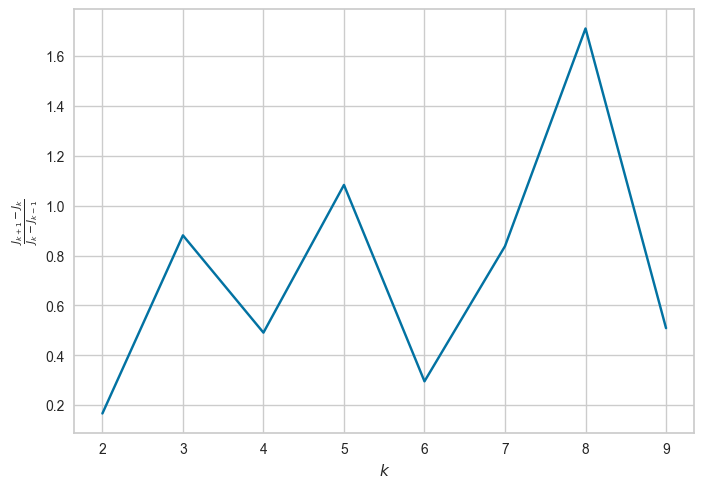

array([0.16647638, 0.88088088, 0.49067412, 1.08307815, 0.2953997 ,
       0.83749095, 1.71060557, 0.50867071])

In [9]:
diff = np.diff(Jk_data_2d)
D = diff[1:] / diff[:-1]
plt.plot(np.arange(2, len(D) + 2), D)
plt.xlabel(r'$k$')
plt.ylabel(r'$\frac{J_{k+1} - J_{k}}{J_{k} - J_{k-1}}$')
plt.show()
D

In [10]:
k_opt = np.argmin(D) + 2
print(k_opt)

2


Судячи з графіку число кластерів для `data_2d` дорівнює $2$, оскільки мінімальне значення величини $\frac{J_{k+1} - J_{k}}{J_{k} - J_{k-1}}$ при $k = 2$. Крім того в наших даних перша колонка скоріше за все є класом ознаки. Таких ознак в даних так $2$-і.

### Автоматичне знаходження кластерів

Число кластерів методом "ліктя" також можна знайти автоматичн, використовуючи бібліотеку [`yellowbrick`](https://www.scikit-yb.org/en/latest/).

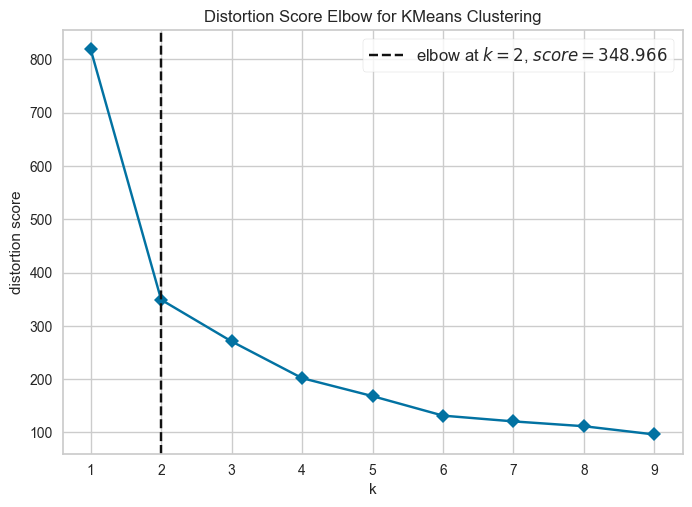

In [11]:
kelbow_data_2d = kelbow_visualizer(KMeans(random_state=0, n_init='auto'), X_data_2d, k=(1,10), timings=False)

Як видно з графіку, методи бібліотеки також дають число кластерів, що дорівнює $2$.

## Запуск алгоритму класифікації

In [12]:
cluster_labels, centroids = perform_kmeans_clustering(X_data_2d, n_clusters=k_opt)

X_ceterod = centroids[:, 0]
y_centroid = centroids[:, 1]

## Візуалізація результат роботи кластеризації

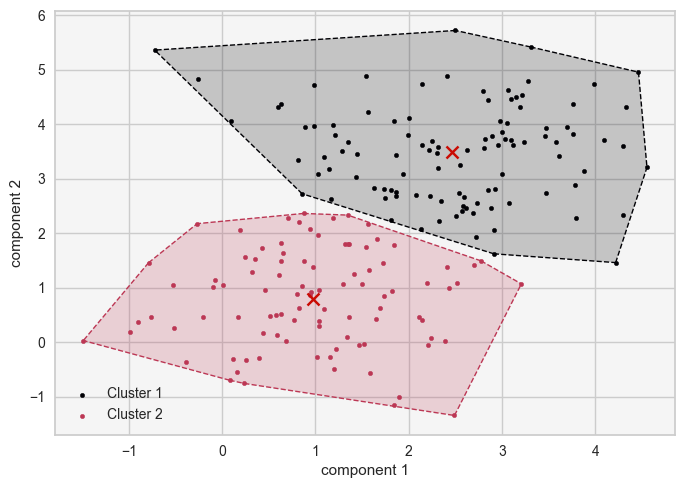

In [13]:
plot_clusters_with_convex_hulls(X_data_2d, cluster_labels, centroids, k_opt)

## Висновки

Метод "ліктя" дає число ознак що дорівнює $2$, що підтверджується самим датасетом, де перша колонка є класом, що якої відносяться ознаки. Таких ознак там теж $2$.


# Датасет `mnist`

In [14]:
mnist = pd.read_csv("data/mnist.csv", header=None)
mnist

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
496,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
497,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
498,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Аналіз даних

In [15]:
X_mnist = mnist.iloc[:, 1:]
y_mnist = mnist.iloc[:, 0]

In [16]:
classes = mnist[0].unique()
classes.sort()
classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

Схоже, що датасет має $10$ кластерів. Ознаки мають характеризувати якусь цифру, можливо, це рукописні образи, як показано на рисунку.

![Alt text](image/digit.png)

## Застосування PCA

PCA (Principal Component Analysis) - це метод, що використовується для зменшення розмірності даних і виділення найбільш інформативних ознак. Основна ідея PCA полягає в проєктуванні багатовимірних даних на меншу кількість вимірів (головних компонентів), при цьому максимізується збереження дисперсії даних. 

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca_mnist = pca.fit_transform(X_mnist)

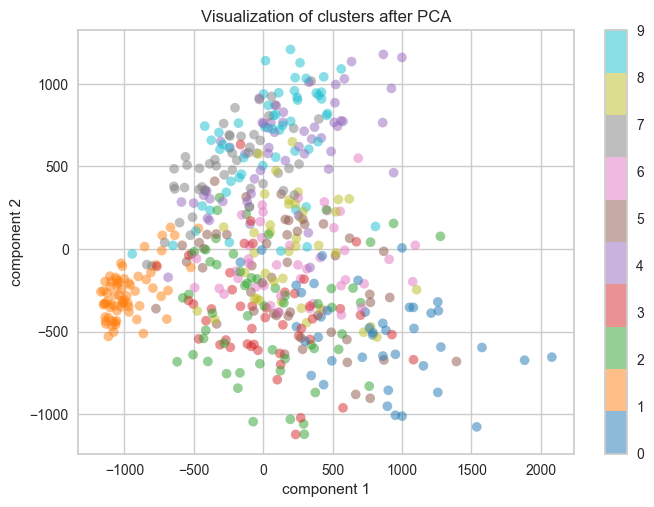

In [18]:
plt.scatter(X_pca_mnist[:, 0], X_pca_mnist[:, 1],
c=y_mnist, edgecolor='none', alpha=0.5,
cmap='tab10')
plt.xlabel('component 1') 
plt.ylabel('component 2') 
plt.colorbar();

plt.title("Visualization of clusters after PCA")
plt.show()

Дивлячись на діаграму розсіювання розфарбовану за класами, що наводяться в датасеті, не видно ніяких кластерів.

Наразі, ці точки - це проекції кожної з точок даних уздовж напрямків максимальної дисперсії. По суті, ми знайшли оптимальні розтягнення і обертання в 784-вимірному просторі, що дають змогу побачити, який вигляд цифри мають у двох вимірах.

## Застосування методу "ліктя"

### На даних без зниження розмірності

In [19]:
random_state=42

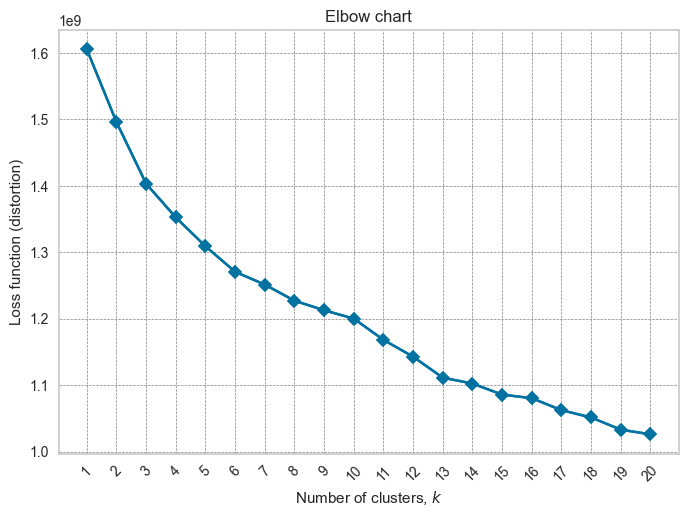

In [20]:
Jk_mnist = find_optimal_clusters(X_mnist, max_clusters=20, random_state=random_state)

Тут не можна надійно візуально визначити кількість кластерів.

### На даних зі зниженням розмірності методом `PCA`

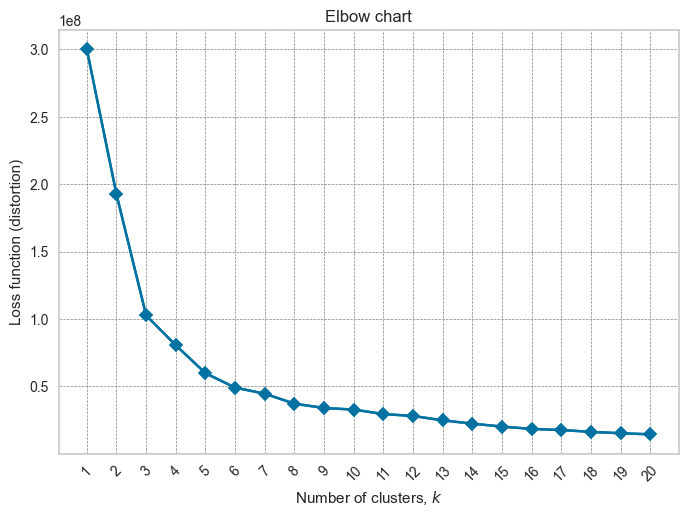

In [21]:
Jk_pca_mnist = find_optimal_clusters(X_pca_mnist, max_clusters=20, random_state=random_state)

### Визначаємо число кластерів

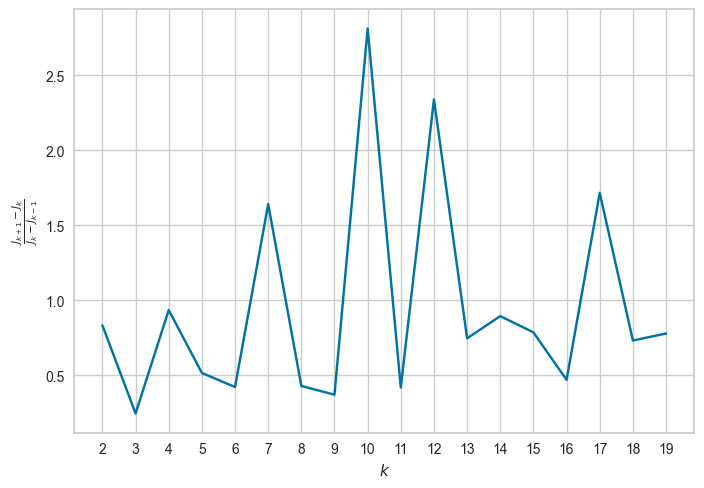

In [22]:
diff = np.diff(Jk_pca_mnist)
D = diff[1:] / diff[:-1]
plt.plot(np.arange(2, len(D) + 2), D)
plt.xticks(np.arange(2, len(D) + 2))
plt.xlabel(r'$k$')
plt.ylabel(r'$\frac{J_{k+1} - J_{k}}{J_{k} - J_{k-1}}$')
plt.show()

На цьому графіку, що побудований з використанням даних зі зниженням розмірності методом `PCA` видно, що число кластерів дорівнює $3$.

In [23]:
k_opt = np.argmin(D) + 2

### Автоматичне знаходження кластерів

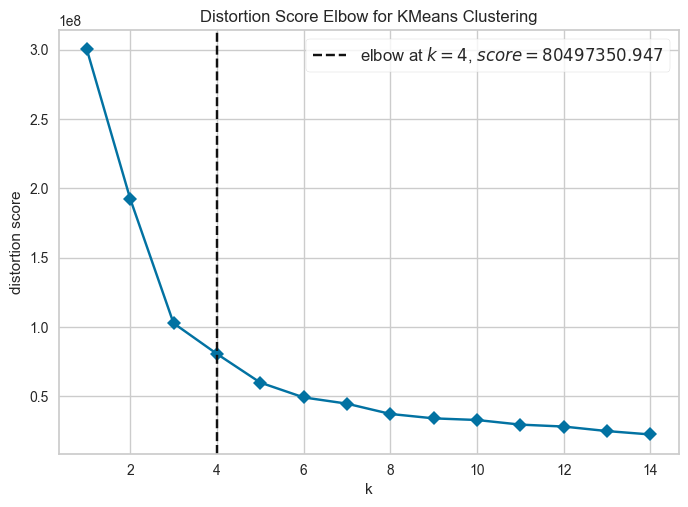

In [24]:
kelbow_pca_mnist = kelbow_visualizer(KMeans(random_state=random_state, n_init='auto'), X_pca_mnist, k=(1,15), timings=False)

Тут цікаво, що число кластерів $k = 4$.

## Запуск алгоритму класифікації

In [25]:
cluster_labels, centroids = perform_kmeans_clustering(X_pca_mnist, n_clusters=k_opt)

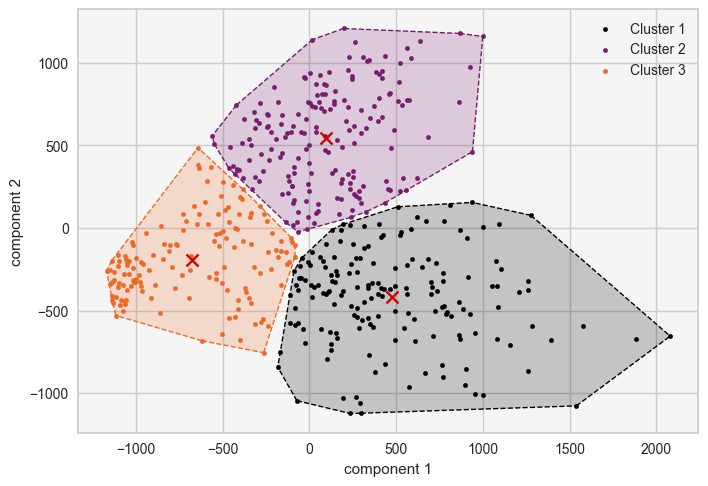

In [26]:
plot_clusters_with_convex_hulls(X_pca_mnist, cluster_labels, centroids, k_opt)

## Висновки

Метод "ліктя" після зниження розмірності (використання `PCA`) дає значення числа кластерів 3. Як це корелює з 10-ма класами (з 10-ма цифрами) не ясно.

Крім того, я помітив, що мінімальне значення сильно залежить від `random_state`. При зміні цього знячення число властерів може бути 12 і 13. Що влизько до значення 10.

Методами бібліотеки `yellowbrick` визначається $k = 4$, при чому, я не помітив, щоб це число залежало від `random_state`.